# Example of upper limit computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statnight.parameters import POI
from statnight.hypotest import UpperLimit
from statnight.calculators import FrequentistCalculator
from statnight.config import Config

In [2]:
import tensorflow as tf
import zfit
from zfit import ztf
from zfit.core.loss import ExtendedUnbinnedNLL, UnbinnedNLL
from zfit.minimizers.minimizer_minuit import MinuitMinimizer

/Users/matthieumarinangeli/anaconda3/envs/tfn/lib/python3.6/site-packages/zfit-0.0.0-py3.6.egg/zfit/util/execution.py:53: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


## Scenario

Let's assume you want to find a resonnance between 0.1 and 3.0 GeV/c$^2$ of invariant mass of a system.

You have a signal region and a background only region:

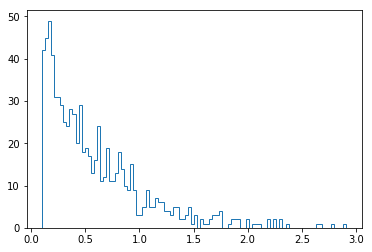

In [3]:
bounds = (0.1,3.0)

#background only
np.random.seed(10)
tau = 2.0
beta = 1./tau
data = np.random.exponential(beta, 1000)

data_bkg = data[(data > bounds[0]) & (data < bounds[1])]
plt.hist(data_bkg, bins=100, histtype='step');

In [4]:
#signal + background

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

### Background fit, in background only region:

The background model is an exponential.

In [5]:
obs = zfit.Space('x', limits=bounds)

In [6]:
lambda_ = zfit.Parameter("lambda_",-2.0, -5.0, -0.1)
model_bkg = zfit.pdf.Exponential(obs=obs, lambda_=lambda_)

In [7]:
data_bkg_ = zfit.data.Data.from_numpy(obs=obs, array=data_bkg)
nll_bkg = UnbinnedNLL(model=[model_bkg], data=[data_bkg_], fit_range=[obs]) 

In [8]:
minimizer = MinuitMinimizer()

In [9]:
min_bkg = minimizer.minimize(loss=nll_bkg)

FCN = 222.38872008604355 
 TOTAL NCALL = 18 
 NCALLS = 18 
 
 
 EDM = 5.955503885843458e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,lambda_,-2.02216,0.0748696,,,-5,-0.1,No


In [10]:
min_bkg.params[lambda_]

{'value': -2.0221553460278447}

In [11]:
min_bkg.error();

Error,-0.0758734282816623,0.07424582735713346
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [12]:
lambda_mu = min_bkg.params[lambda_]["value"]
lambda_sigma = 0.0748696
print(lambda_mu, lambda_sigma)

-2.0221553460278447 0.0748696


### Signal + background fit in signal region:

The total model is a sum of a gaussian and an exponential. The tau parameter of the exponential will be constrained to the value obtained in the background only region.

In [13]:
mean = zfit.Parameter("mean", 1.2, 0.1, 2., floating=False)
sigma = zfit.Parameter("sigma", 0.1, floating=False)
Nsig = zfit.Parameter("Nsig", 1., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [14]:
signal = Nsig * zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
background =  Nbkg * model_bkg
tot_model = signal + background

In [15]:
constraint = zfit.constraint.nll_gaussian(params=[lambda_], mu=[lambda_mu], sigma=[lambda_sigma])

In [16]:
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=[tot_model], data=[data_], fit_range=[obs], constraints=constraint) 

In [17]:
minimum = minimizer.minimize(loss=nll)

FCN = -1077.3102158175611 
 TOTAL NCALL = 68 
 NCALLS = 68 
 
 
 EDM = 3.616396431133066e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,250.491,16.5058,,,0,281.6,No
1,lambda_,-2.00252,0.0665394,,,-5,-0.1,No
2,Nsig,5.54879,5.48997,,,-20,256,No


In [18]:
def plotfitresult(pdf, bounds, nbins, data):
    x = np.linspace(*bounds, num=1000)
    pdf = zfit.run(tot_model.pdf(x, norm_range=bounds))
    _ = plt.plot(x, ((bounds[1] - bounds[0])/nbins)*(pdf), "-r")  

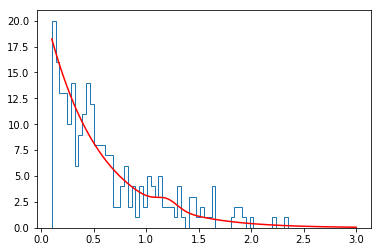

In [19]:
nbins = 80
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(tot_model, bounds, nbins, data)

## Upper limit:

In [20]:
from scipy.stats import norm

In [21]:
from contextlib import ExitStack

def profileLikelihood(loss, var, value):
    with var.set_value(value) as value:
        var.floating = False
        mini = minimizer
        mini.verbosity = 0
        minimum = mini.minimize(loss=loss)
    var.floating = True
    return minimum.fmin

def samplers(constraints):
    def s(ntoys, param, value, models, nsamples="extended"):
    
        to_set = {param: value}

        fixed_params = [lambda_, Nbkg]
        samplers = [m.create_sampler(n=nsamples, fixed_params=fixed_params) for m in models]
    
        def iterate():
            for i in range(ntoys):            
                values_to_set = dict(to_set)
            
                for k, v in constraints.items():
                    values_to_set[k] = v()

                with ExitStack() as stack:
                    items = values_to_set.items()
                    [stack.enter_context(k.set_value(v)) for k, v in items]
                    for s in samplers:
                        s.resample()
                
                yield i
    
        return samplers, iterate()
    return s

def lossbuilder(model, data, weights=None):
    constraint = zfit.constraint.nll_gaussian(params=[lambda_], mu=[lambda_mu], sigma=[lambda_sigma])
    loss = ExtendedUnbinnedNLL(model=model, data=data, fit_range=[obs], constraints=constraint) 
    return loss

constraints = {lambda_: lambda: norm.rvs(loc=lambda_mu, scale=lambda_sigma)}
    
config = Config(tot_model, data_, lossbuilder, MinuitMinimizer(), profileLikelihood, samplers(constraints))

In [22]:
config.bestfit

Get fit best values!


FCN = -1077.3102191386088 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 3.284304874885505e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,Nbkg,250.491,16.5058,,,0,281.6,No
1,lambda_,-2.00246,0.0665391,,,-5,-0.1,No
2,Nsig,5.5488,5.48997,,,-20,256,No


In [23]:
calc = FrequentistCalculator(config, ntoysnull=2000, ntoysalt=4000)

In [24]:
poinull = POI(Nsig, value=np.linspace(0.1, 25, 15))
poialt = POI(Nsig, value=0)
ul_test = UpperLimit(poinull, poialt, calc, CLs=True, qtilde=False)

In [25]:
ul_test.upperlimit();

Generating null hypothesis toys for POI('Nsig', value=0.1).
0 toys generated, fitted and scanned!
400 toys generated, fitted and scanned!
800 toys generated, fitted and scanned!
1200 toys generated, fitted and scanned!
1600 toys generated, fitted and scanned!
Generating null hypothesis toys for POI('Nsig', value=1.8785714285714286).
0 toys generated, fitted and scanned!
400 toys generated, fitted and scanned!
800 toys generated, fitted and scanned!
1200 toys generated, fitted and scanned!
1600 toys generated, fitted and scanned!
Generating null hypothesis toys for POI('Nsig', value=3.657142857142857).
0 toys generated, fitted and scanned!
400 toys generated, fitted and scanned!
800 toys generated, fitted and scanned!
1200 toys generated, fitted and scanned!
1600 toys generated, fitted and scanned!
Generating null hypothesis toys for POI('Nsig', value=5.435714285714285).
0 toys generated, fitted and scanned!
400 toys generated, fitted and scanned!
800 toys generated, fitted and scanned!

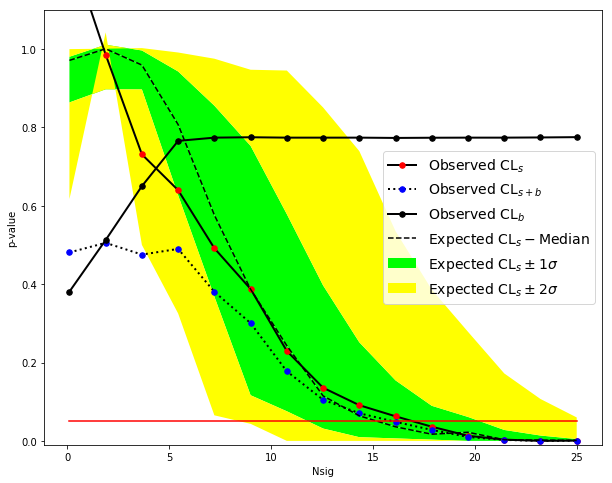

In [26]:
ul_test.plot()

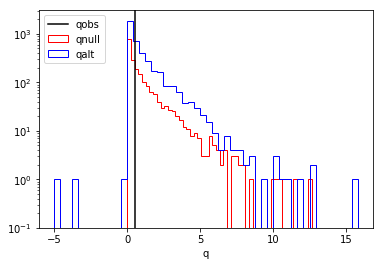

In [27]:
ul_test.plot_qdist(poinull[1], log=True)

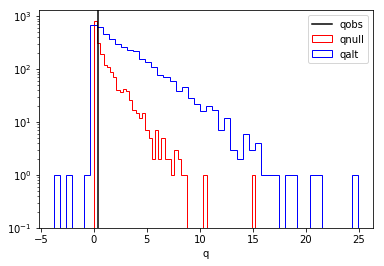

In [28]:
ul_test.plot_qdist(poinull[5], log=True)

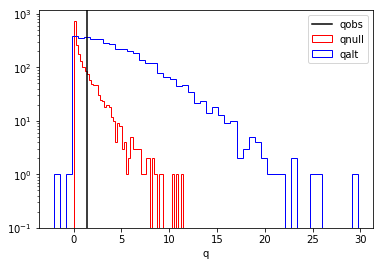

In [29]:
ul_test.plot_qdist(poinull[7], log=True)

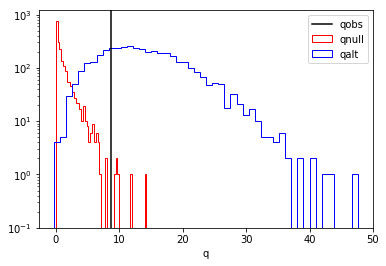

In [30]:
ul_test.plot_qdist(poinull[-1], log=True)